<a href="https://www.kaggle.com/code/shwetakolekar/email-spam-classifier?scriptVersionId=164363120" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.svm import SVC
import warnings
from sklearn.preprocessing import LabelEncoder
import nltk
import string

In [79]:
df=pd.read_csv("/kaggle/input/spam-email-detection/Spam Email Detection - spam.csv")

In [80]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


* # **Data Cleaning**

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [82]:
#drop 3 columns
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace = True)

In [83]:
df.shape

(5572, 2)

In [84]:
#renaming colunms
df.rename(columns={'v1':'target','v2':'mail'},inplace=True)
df.head()

,target,mail
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [85]:
#perform encoding
encoder=LabelEncoder()
df['target']=encoder.fit_transform(df['target'])
df.head()

,target,mail
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [86]:
#missing values
df.isnull().sum()

target    0
mail      0
dtype: int64

In [87]:
#check for duplicated value
df.duplicated().sum()

409

In [88]:
df=df.drop_duplicates(keep='first')

In [89]:
df.duplicated().sum()

0

In [90]:
df.shape

(5163, 2)

* # **EDA**

In [91]:
df['target'].value_counts()

target
0    4516
1     647
Name: count, dtype: int64

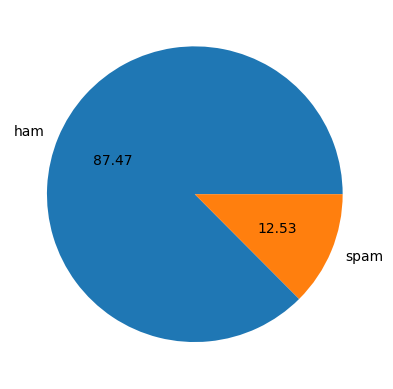

In [92]:
plt.pie(df['target'].value_counts(),labels=['ham','spam'],autopct='%0.2f')
plt.show()

**Data is imbalanced**

In [93]:
df['num_char']=df['mail'].apply(len)
df.head()

,target,mail,num_char
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [94]:
df['num_words']=df['mail'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

,target,mail,num_char,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,23
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [95]:
df['num_sentence']=df['mail'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,target,mail,num_char,num_words,num_sentence
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [96]:
#ham
df[df['target']==0][['num_char','num_words','num_sentence']].describe()

,num_char,num_words,num_sentence
count,4516.000000,4516.000000,4516.000000
mean,70.428919,16.957484,1.815545
std,56.356310,13.394052,1.364098
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,219.000000,38.000000


In [97]:
#spam
df[df['target']==1][['num_char','num_words','num_sentence']].describe()

,num_char,num_words,num_sentence
count,647.000000,647.000000,647.000000
mean,137.318393,27.465224,2.965997
std,30.096861,6.921829,1.490554
min,13.000000,2.000000,1.000000
25%,130.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,44.000000,9.000000


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='num_char', ylabel='Count'>

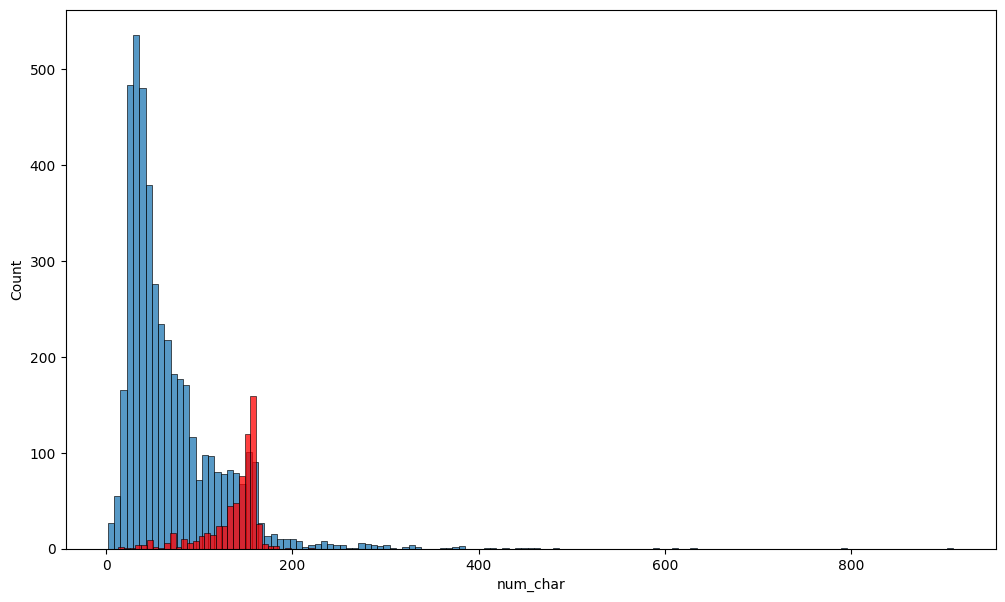

In [98]:
plt.figure(figsize=(12,7))
sns.histplot(df[df['target']==0]['num_char'])
sns.histplot(df[df['target']==1]['num_char'],color='red')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


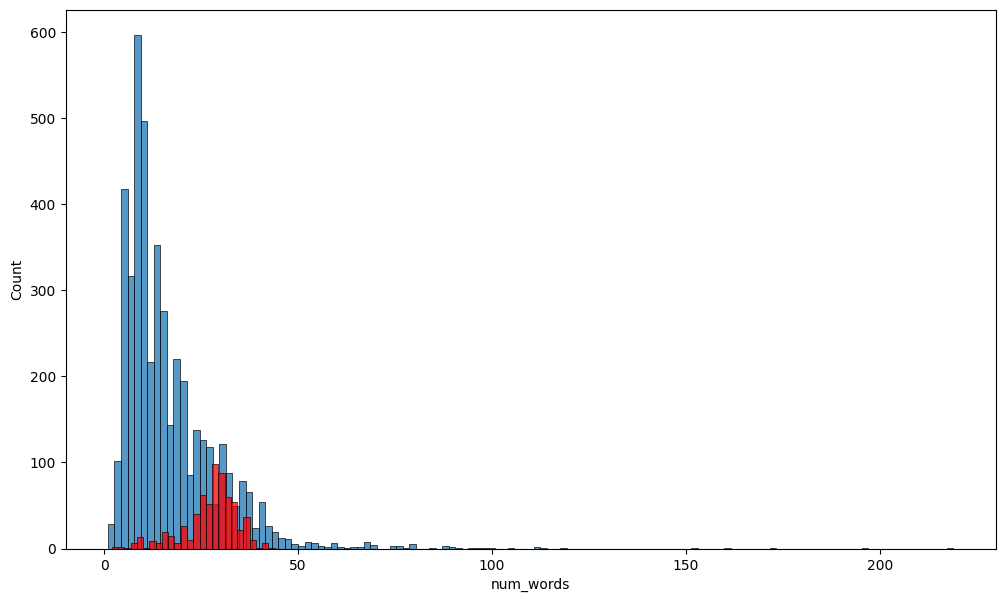

In [99]:
plt.figure(figsize=(12,7))
sns.histplot(df[df['target']==0]['num_words'])
sns.histplot(df[df['target']==1]['num_words'],color='red')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

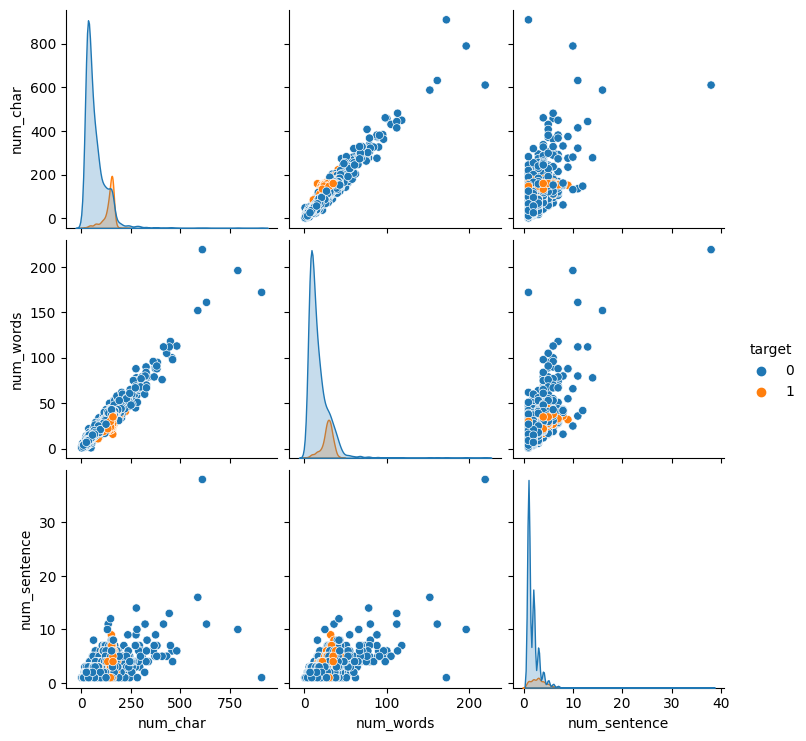

In [100]:
sns.pairplot(df,hue='target')
plt.show()

<Axes: >

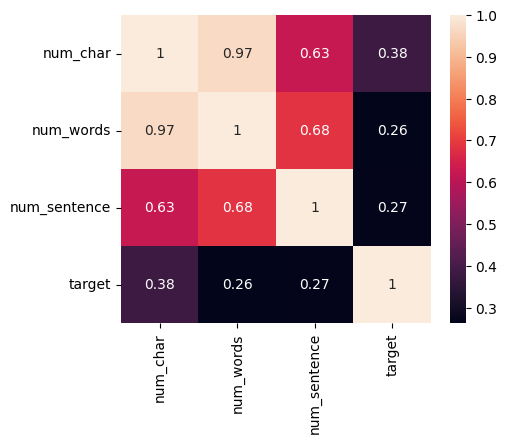

In [101]:
columns=['num_char','num_words','num_sentence','target']
numeric_data=df[columns]

#heatmap plot
correlation_marix=numeric_data.corr()
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_marix,annot=True)


* # **Data Preprocessing**

* Lower case
* Tokenization
* Removing Special Characters
* Removig stop words and punctuation
* Stemming

In [102]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')
import string
string.punctuation
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
ps.stem('Roaming')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'roam'

In [103]:
def transform_text(mail):
    mail=mail.lower()
    mail=nltk.word_tokenize(mail)
    
    y=[]
    for i in mail:
        if i.isalnum():
            y.append(i)
            
    mail=y[:]
    y.clear()
    
    for i in mail:
        if i not in stopwords.words("english") and i not in string.punctuation:
            y.append(i)
            
    text=y[:]
    y.clear()
    
    for i in mail:
        y.append(ps.stem(i))
        
    return " ".join (y)

In [104]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'i gon na be home soon and i do want to talk about thi stuff anymor tonight k i cri enough today'

In [105]:
df['mail'][10]

"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

In [106]:
ps=PorterStemmer()
ps.stem("dancing")

'danc'

In [107]:
df["tarnsformed_mail"]=df["mail"].apply(transform_text)

In [108]:
df.head()

,target,mail,num_char,num_words,num_sentence,tarnsformed_mail
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2,go until jurong point avail onli in bugi n gre...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri in 2 a wkli comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say so earli hor u c alreadi then say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i do think he goe to usf he live around he...


* # **Model Building**

In [139]:
from sklearn.feature_extraction.text import  CountVectorizer,TfidfVectorizer
cv= CountVectorizer()
tfidf=TfidfVectorizer()

In [140]:
x=tfidf.fit_transform(df['tarnsformed_mail']).toarray()
x.shape

(5163, 6687)

In [141]:
y=df['target'].values
y

array([0, 0, 1, ..., 0, 0, 0])

In [142]:
from sklearn.model_selection import train_test_split

In [143]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=2)

In [144]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [145]:
gnb=GaussianNB()
mnb=MultinomialNB()
bnb=BernoulliNB()

In [146]:
gnb.fit(x_train,y_train)
y_pred1 =gnb.predict(x_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.8664085188770572
[[788 124]
 [ 14 107]]
0.46320346320346323


In [147]:
mnb.fit(x_train,y_train)
y_pred2 =mnb.predict(x_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9506292352371732
[[912   0]
 [ 51  70]]
1.0


In [148]:
bnb.fit(x_train,y_train)
y_pred3 =bnb.predict(x_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9719264278799613
[[908   4]
 [ 25  96]]
0.96


In [156]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [158]:
svc=SVC(kernel="sigmoid",gamma=1.0)
knc=KNeighborsClassifier()
mnb=mnb=MultinomialNB()
dtc= DecisionTreeClassifier(max_depth=5)
lrc= LogisticRegression(solver='liblinear',penalty='l1')
rfc=RandomForestClassifier(n_estimators=50,random_state=2)

In [159]:
clfs={
    'SVC':svc,
    'KN':knc,
    'NB':mnb,
    "DT":dtc,
    'LR':lrc,
    "RF":rfc
}

In [162]:
def train_classifier(clf,x_train,y_train,x_test,y_test):
    clf.fit(x_train,y_train)
    y_pred=clf.predict(x_test)
    accuracy=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    
    return accuracy,precision

In [164]:
train_classifier(svc,x_train,y_train,x_test,y_test)

(0.9777347531461762, 0.9803921568627451)

In [168]:
accuracy_scores=[]
precision_scores=[]
for name,clf in  clfs.items():
    current_accuracy,current_precision=train_classifier(clf,x_train,y_train,x_test,y_test)
    
    print("For",name)
    print("Accuracy- ",current_accuracy)
    print("Precision -",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision) 
    

For SVC
Accuracy-  0.9777347531461762
Precision - 0.9803921568627451
For KN
Accuracy-  0.9138431752178122
Precision - 1.0
For NB
Accuracy-  0.9506292352371732
Precision - 1.0
For DT
Accuracy-  0.9351403678606002
Precision - 0.7755102040816326
For LR
Accuracy-  0.9583736689254598
Precision - 0.9333333333333333
For RF
Accuracy-  0.9690222652468539
Precision - 0.989010989010989


In [175]:
performance_df=pd.DataFrame({"Algorithm":clfs.keys(),"Accuracy":accuracy_scores,"Precision":precision_scores}).sort_values("Precision",ascending=False)
performance_df

,Algorithm,Accuracy,Precision
1,KN,0.913843,1.000000
2,NB,0.950629,1.000000
5,RF,0.969022,0.989011
0,SVC,0.977735,0.980392
4,LR,0.958374,0.933333
3,DT,0.935140,0.775510


**Here We choose TfidfVectorizer and MultinomialNB model.Our data is imbalanced so Precision matters alot.And this model gives high precision.**